# Speech Emotion Recognition with Random Forest

In this notebook, we build and evaluate a Random Forest classifier for speech emotion recognition. We are using three CSV files:

- **train_final.csv**: For training the model.
- **val_final.csv**: For optional validation purposes and/or to combine with the training set for hyperparameter tuning.
- **test_final.csv**: For final, unbiased evaluation.

We’ll walk through the following sections:

1. Data Loading & Exploration
2. Data Preprocessing
3. Baseline Random Forest Model
4. Hyperparameter Tuning
5. Final Evaluation on Test Data
6. Conclusion and Future Steps

## 1. Data Loading & Exploration

In this section, we load our datasets into Pandas DataFrames.

In [1]:
import pandas as pd

# Load the datasets
train_df = pd.read_csv('../data/features/train_final.csv')
val_df = pd.read_csv('../data/features/val_final.csv')
test_df = pd.read_csv('../data/features/test_final.csv')

# Combine train_df & val_df into one dataframe as we do not need the validation set for our training
full_train_df = pd.concat([train_df, val_df], axis=0, ignore_index=True)

print("Combined shape:", full_train_df.shape)
print(full_train_df['Emotion'].value_counts())

Combined shape: (52905, 52)
Emotion
Neutral     12500
Happy       10707
Question     6452
Bored        6222
Anger        5050
Sad          4727
Surprise     4126
Fear         1605
Disgust      1516
Name: count, dtype: int64


## 2. Data Preprocessing

For this project, our dataset contains the following columns:

- **Filepath:** Path to the audio file (not used for model training)
- **PC1, PC2, ..., PC129:** Numerical features (likely principal components from prior feature reduction)
- **Emotion:** The target variable containing the emotion labels

We will:

- Exclude the `Filepath` column.
- Use all the `PC` columns as features.
- Set `Emotion` as our target variable.

Note: Unlike distance-based methods (e.g., KNN), Random Forests are generally robust to feature scaling. So, in this notebook we will skip scaling unless needed for consistency.

In [2]:
# Define the target column
target_column = 'Emotion'

# Automatically select feature columns by excluding 'Filepath' and the target column
feature_columns = train_df.columns.difference(['Filepath', target_column])

# Create features (X) and target (y) for training, validation, and testing
X_train = full_train_df[feature_columns]
Y_train = full_train_df[target_column]

X_test = test_df[feature_columns]
Y_test = test_df[target_column]

## 3. Baseline Random Forest Model

First, we build a baseline Random Forest model using default hyperparameters. This will serve as our initial performance benchmark before any tuning is performed.

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

# Build a Random Forest with default settings
baseline_rf = RandomForestClassifier(random_state=42)
baseline_rf.fit(X_train, Y_train)

# Predict on the test set
Y_test_pred = baseline_rf.predict(X_test)

# Compute metrics
accuracy  = accuracy_score(Y_test, Y_test_pred)
precision = precision_score(Y_test, Y_test_pred, average='weighted')
recall    = recall_score(Y_test, Y_test_pred,    average='weighted')
f1        = f1_score(Y_test, Y_test_pred,        average='weighted')

# Print results
print(f"Baseline RF Test Accuracy : {accuracy:.4f}")
print(f"Baseline RF Test Precision: {precision:.4f}")
print(f"Baseline RF Test Recall   : {recall:.4f}")
print(f"Baseline RF Test F1‑Score : {f1:.4f}\n")

print("Detailed classification report:\n")
print(classification_report(Y_test, Y_test_pred))

Baseline RF Test Accuracy : 0.6301
Baseline RF Test Precision: 0.6334
Baseline RF Test Recall   : 0.6301
Baseline RF Test F1‑Score : 0.6261

Detailed classification report:

              precision    recall  f1-score   support

       Anger       0.66      0.66      0.66       891
       Bored       0.65      0.85      0.74      1098
     Disgust       0.57      0.38      0.45       273
        Fear       0.60      0.37      0.46       285
       Happy       0.62      0.55      0.58      1885
     Neutral       0.57      0.68      0.62      2203
    Question       0.73      0.66      0.69      1139
         Sad       0.64      0.60      0.62       830
    Surprise       0.69      0.53      0.60       728

    accuracy                           0.63      9332
   macro avg       0.64      0.58      0.60      9332
weighted avg       0.63      0.63      0.63      9332



## 4. Hyperparameter Tuning

Next, we optimize the Random Forest model by tuning key hyperparameters. The following parameters will be tuned:

- **n_estimators:** Number of trees in the forest (e.g., 100, 200).
- **max_depth:** Maximum depth of the trees (e.g., None, 10, 20).
- **min_samples_split:** Minimum samples required to split an internal node (e.g., 2, 5).
- **max_features:** Number of features to consider when looking for the best split (e.g., 'sqrt', 'log2').

We use `GridSearchCV` with 5-fold cross-validation on the training data to perform an exhaustive search over the hyperparameter space.

In [4]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

# Instantiate the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the grid search on the training data
grid_search.fit(X_train, Y_train)

print("Best Hyperparameters:")
print(grid_search.best_params_)

print("\nBest Cross-Validation Score:")
print(grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Hyperparameters:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}

Best Cross-Validation Score:
0.6380871373216142


## 5. Final Evaluation on Test Data

After hyperparameter tuning, we retrieve the best Random Forest model using `grid_search.best_estimator_` and evaluate its performance on the test dataset. This gives us an unbiased estimate of the model's performance on unseen data.

Final KNN Test Accuracy : 0.6443
Final KNN Test Precision: 0.6491
Final KNN Test Recall   : 0.6443
Final KNN Test F1‑Score : 0.6402

Final Classification Report:

              precision    recall  f1-score   support

       Anger       0.68      0.66      0.67       891
       Bored       0.66      0.86      0.75      1098
     Disgust       0.61      0.40      0.48       273
        Fear       0.63      0.35      0.45       285
       Happy       0.64      0.56      0.60      1885
     Neutral       0.57      0.70      0.63      2203
    Question       0.75      0.68      0.71      1139
         Sad       0.66      0.61      0.63       830
    Surprise       0.71      0.55      0.62       728

    accuracy                           0.64      9332
   macro avg       0.66      0.60      0.62      9332
weighted avg       0.65      0.64      0.64      9332



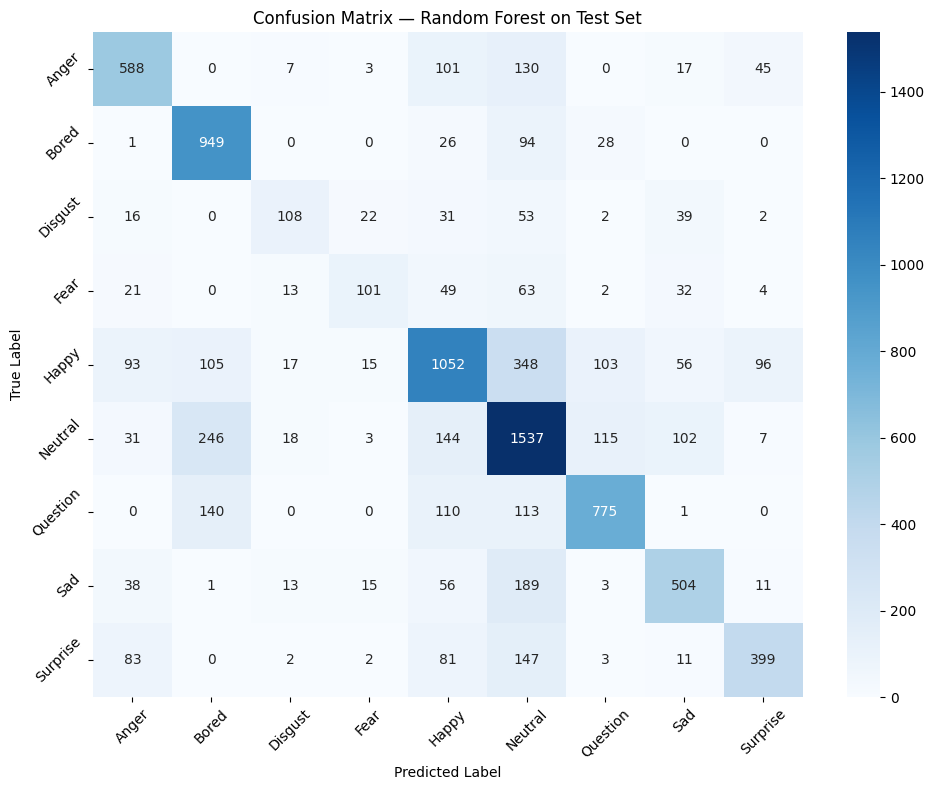

In [5]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get the best Random Forest model from grid search
best_rf = grid_search.best_estimator_ # Automatically returns a new KNeighborsClassifer Object preconfigured with the best hyperparameters fund during grid search

# Evaluate the best model on the test data
Y_test_pred = best_rf.predict(X_test)

# Compute metrics
accuracy  = accuracy_score(Y_test, Y_test_pred)
precision = precision_score(Y_test, Y_test_pred, average='weighted')
recall    = recall_score(Y_test, Y_test_pred,    average='weighted')
f1        = f1_score(Y_test, Y_test_pred,        average='weighted')

# Print results
print(f"Final KNN Test Accuracy : {accuracy:.4f}")
print(f"Final KNN Test Precision: {precision:.4f}")
print(f"Final KNN Test Recall   : {recall:.4f}")
print(f"Final KNN Test F1‑Score : {f1:.4f}\n")

print("Final Classification Report:\n")
print(classification_report(Y_test, Y_test_pred))

# Compute the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_test_pred)

# Get the list of emotion labels in the right order
labels = best_rf.classes_  # this will be ['Anger','Bored',...,'Surprise']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix — Random Forest on Test Set')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

## 6. Conclusion

In this notebook, we achieved the following:

- **Data Exploration:** Loaded and inspected the datasets, checked for missing values, and understood the structure (features and target).
- **Data Preprocessing:** Selected the appropriate feature columns (all PC columns excluding `Filepath`) and designated `Emotion` as the target variable. Note that scaling was deemed unnecessary for Random Forest.
- **Baseline Model:** Built a baseline Random Forest with default parameters to establish an initial performance benchmark.
- **Hyperparameter Tuning:** Optimized critical parameters of the Random Forest using GridSearchCV with cross-validation.
- **Final Evaluation:** Assessed the tuned model on a separate test set to obtain an unbiased estimate of its performance.